In [47]:
# import builtins
# original_print = print
# def custom_print(*args, **kwargs):
#     new_args = []
#     for arg in args:
#         if isinstance(arg, float):
#             new_args.append(f'{arg:.10f}')
#         else:
#             new_args.append(arg)
#     original_print(*new_args, **kwargs)
# builtins.print = custom_print

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta

plt.rcParams['figure.constrained_layout.use'] = True

In [49]:
# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

data = pd.read_csv('../5_processing_extracted_data/hardware_instances_with_efficiency.csv') # date,row_index,hardware_name,TH/J

# Convert the 'date' column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# keep only data from 2011 onwards
data = data[data['date'] >= '2011-01-05']
data

,date,hardware_name,TH/J
8,2011-02-19 09:38:19,5970,0.000002
9,2011-02-22 04:58:02,6870,0.000002
10,2011-02-24 14:36:52,5970,0.000002
11,2011-02-27 21:32:08,5870,0.000002
12,2011-02-28 16:33:47,5570,0.000002
...,...,...,...
14530,2023-12-17 03:45:25,microbt whatsminer m30s,0.026316
14531,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461
14532,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461
14533,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461


In [50]:
# Step 1: Average the data points on a quarterly basis
# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')

# Create a 'quarter' column by offsetting the 'date' by 15 days and then using to_period
data['quarter'] = (data['date'] - timedelta(days=45)).dt.to_period('Q')
# data['quarter'] = (data['date'] - timedelta(days=0)).dt.to_period('Q')
data

,date,hardware_name,TH/J,quarter
8,2011-02-19 09:38:19,5970,0.000002,2011Q1
9,2011-02-22 04:58:02,6870,0.000002,2011Q1
10,2011-02-24 14:36:52,5970,0.000002,2011Q1
11,2011-02-27 21:32:08,5870,0.000002,2011Q1
12,2011-02-28 16:33:47,5570,0.000002,2011Q1
...,...,...,...,...
14530,2023-12-17 03:45:25,microbt whatsminer m30s,0.026316,2023Q4
14531,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461,2023Q4
14532,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461,2023Q4
14533,2023-12-17 03:45:25,microbt whatsminer m50s,0.038461,2023Q4


In [51]:
# Group by 'quarter' and calculate the mean of 'TH/J'
quarterly_data = data.groupby('quarter')['TH/J'].mean().reset_index()

# Convert 'quarter' back to datetime (last day of the quarter)
quarterly_data['quarter'] = quarterly_data['quarter'].dt.to_timestamp(freq='Q')
# # Convert 'quarter' back to datetime (first day of the quarter)
# quarterly_data['quarter'] = quarterly_data['quarter'].dt.to_timestamp()
quarterly_data.head(3)

,quarter,TH/J
0,2011-03-31,0.000002
1,2011-06-30,0.000002
2,2011-09-30,0.000002


In [52]:
# add a 2011-01-01 row to the quarterly_data and copy the first row to it
# create timestamp for 2011-01-01
ts = pd.Timestamp('2011-01-01')
quarterly_data.loc[-1] = [ts, quarterly_data['TH/J'][0]]
quarterly_data.index = quarterly_data.index + 1
quarterly_data = quarterly_data.sort_index()
quarterly_data

,quarter,TH/J
0,2011-01-01,0.000002
1,2011-03-31,0.000002
2,2011-06-30,0.000002
3,2011-09-30,0.000002
4,2011-12-31,0.000002
5,2012-03-31,0.000004
6,2012-06-30,0.000004
7,2012-09-30,0.000005
8,2012-12-31,0.000035
9,2013-03-31,0.000075


In [53]:

# obtain monthly data
data['month'] = data['date'].dt.to_period('M')
monthly_data = data.groupby('month')['TH/J'].mean().reset_index()
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()


In [54]:

dpi = 110


# unit = "TH/J"
unit = "H/J"
# func = "ln"
func = "log10"
def process(x,apply_multiplier=False):
    multi = 1e12 if unit == "H/J" else 1
    if apply_multiplier == False:
        multi = 1
    if func == "ln":
        return np.log(x*multi)
    if func == "log10":
        return np.log10(x*multi)

In [55]:
process(data[unit_power_efficiency])

8       -5.697821
9       -5.762859
10      -5.697821
11      -5.719877
12      -5.757061
           ...   
14530   -1.579784
14531   -1.414979
14532   -1.414979
14533   -1.414979
14534   -1.414979
Name: TH/J, Length: 14527, dtype: float64

In [56]:
gray_scatter_x = data['date'] # looks like 2011-02-19 09:38:19
gray_scatter_y = process(data[unit_power_efficiency],apply_multiplier=True) # looks like 6.302179

red_scatter_x = quarterly_data['quarter'] # looks like 2011-01-01
red_scatter_y = process(quarterly_data['TH/J'],apply_multiplier=True) # looks like 6.217607 (average of that time period)

lime_scatter_x = monthly_data['month'] # looks like 2011-01-01
lime_scatter_y = process(monthly_data['TH/J'],apply_multiplier=True) # looks like 6.217607 (average of that time period)

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../../hardwarelist/pmaxv3.csv')
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])
max_plot_x = max_efficiency_table['date']
max_plot_y = process(max_efficiency_table['max_efficiency']*1e-12,apply_multiplier=True)

In [58]:
monthly_price_joules = pd.read_csv('../6_merging/monthly_stuff.csv') # date,price,hashrate,coins_per_block,efficiency,max_efficiency
monthly_price_joules["real_joules_per_coin"] = monthly_price_joules["hashrate"] / (monthly_price_joules["efficiency"] * monthly_price_joules["coins_per_block"])

price_plot_x = pd.to_datetime(monthly_price_joules['date'])
price_plot_y = process(monthly_price_joules['price'])

joules_plot_x = pd.to_datetime(monthly_price_joules['date'])
joules_plot_y = process(monthly_price_joules['real_joules_per_coin'])



price_offset = 0
price_plot_y = price_plot_y + price_offset

joules_offset = 0
joules_plot_y = joules_plot_y + joules_offset

time_to_double = 2.6
# koomey's law: after 2018, the efficiency doubles every 2.6 years
first_2018_efficiency = quarterly_data[quarterly_data['quarter'] == '2017-12-31']['TH/J'].values[0] # 2018-01-01
koomey_preds_efficiency = []
for i in range(4*(2024-2018)+1):
    koomey_preds_efficiency.append(first_2018_efficiency * 2**((i/4)/time_to_double))
koomey_preds_efficiency = np.array(koomey_preds_efficiency)
koomey_preds_efficiency = process(koomey_preds_efficiency,apply_multiplier=True)
koomey_preds_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_efficiency), freq='Q')

# koomey's law for joules:
first_2018_joules = monthly_price_joules[monthly_price_joules['date'] == '2017-12-31']['real_joules_per_coin'].values[0]
koomey_preds_joules = []
for i in range(12*(2024-2018)+1):
    koomey_preds_joules.append(first_2018_joules * 2**((i/12)/time_to_double))
koomey_preds_joules = np.array(koomey_preds_joules)
koomey_preds_joules = process(koomey_preds_joules)
koomey_preds_joules_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_joules), freq='M')

# koomey's law for price:
first_2018_price = monthly_price_joules[monthly_price_joules['date'] == '2017-12-31']['price'].values[0]
koomey_preds_price = []
for i in range(12*(2024-2018)+1):
    koomey_preds_price.append(first_2018_price * 2**((i/12)/time_to_double))
koomey_preds_price = np.array(koomey_preds_price)
koomey_preds_price = process(koomey_preds_price)
koomey_preds_price_x = pd.date_range(start='2018-01-01', periods=len(koomey_preds_price), freq='M')


In [59]:
yearly_counts = gray_scatter_x.dt.year.value_counts().sort_index()
print(yearly_counts.mean(),yearly_counts.std())
# export to latex
print(yearly_counts.to_frame().T.to_latex())

1117.4615384615386 686.785703523379
\begin{tabular}{lrrrrrrrrrrrrr}
\toprule
date & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 & 2022 & 2023 \\
\midrule
count & 1146 & 803 & 2001 & 2379 & 1899 & 1320 & 1569 & 1160 & 575 & 363 & 644 & 422 & 246 \\
\bottomrule
\end{tabular}



In [60]:
# plt.rcParams["text.usetex"] =  True

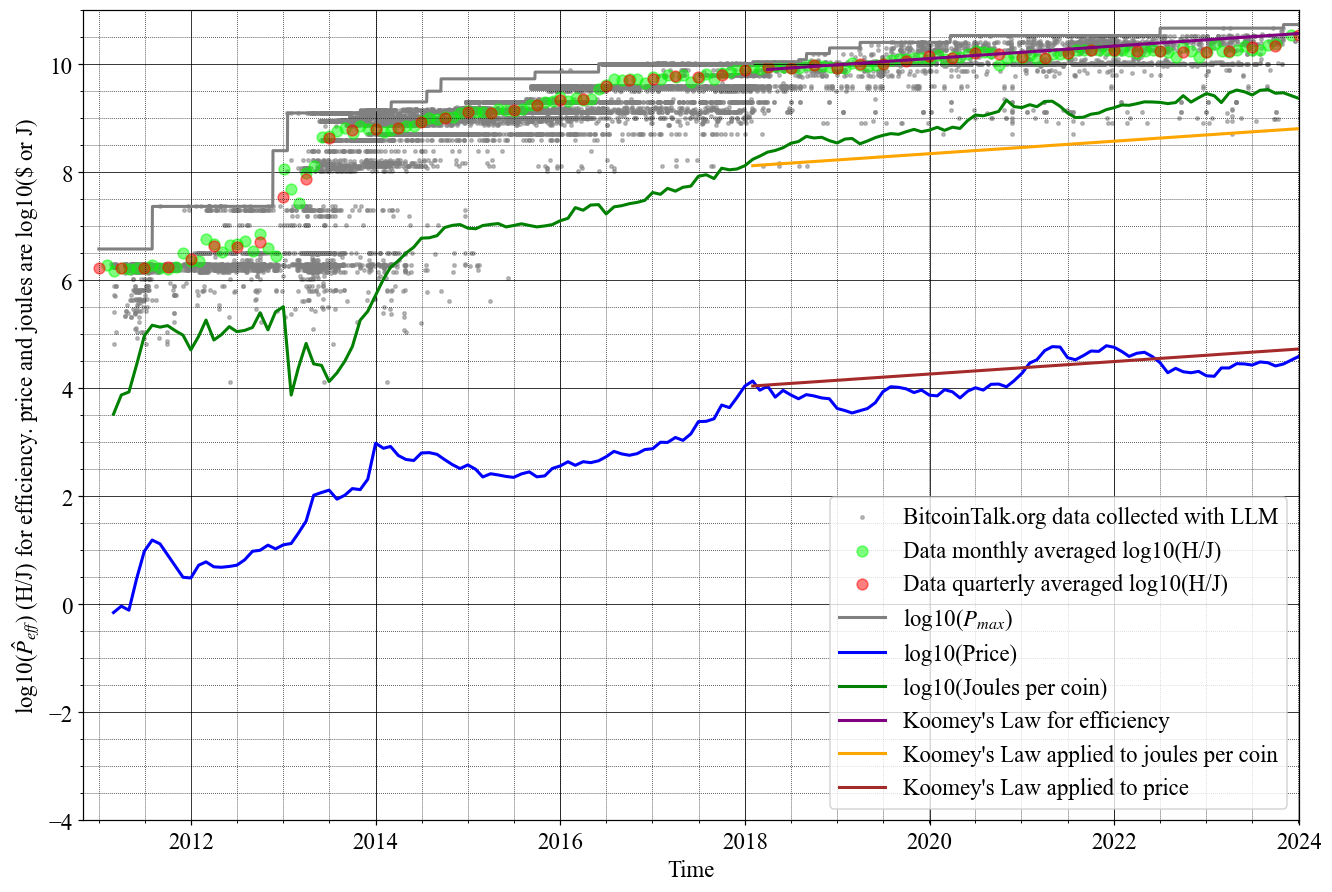

In [61]:

plt.rcParams['font.family'] = 'Times New Roman'

plt.rcParams.update({'font.size': 15})

koomey_extra = " starting 2018"
koomey_extra = ""

# Step 4: Plot single point for each quarter + all the data points using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(gray_scatter_x, gray_scatter_y, c='gray', s=5, label='BitcoinTalk.org data collected with LLM', alpha=0.5)
plt.scatter(lime_scatter_x, lime_scatter_y, c='lime', s=50, label=f'Data monthly averaged {func}({unit})', alpha=0.5)
plt.scatter(red_scatter_x, red_scatter_y, c='red', s=50, label=f'Data quarterly averaged {func}({unit})', alpha=0.5)
plt.plot(max_plot_x, max_plot_y, color='gray', label=func+'($P_{max}$)', linewidth=2)
plt.plot(price_plot_x, price_plot_y, color='blue', label=func+'(Price)'+("" if price_offset == 0 else str(price_offset)), linewidth=2)
plt.plot(joules_plot_x, joules_plot_y, color='green', label=func+'(Joules per coin)'+("" if joules_offset == 0 else str(joules_offset)), linewidth=2)
plt.plot(koomey_preds_x, koomey_preds_efficiency, color='purple', label='Koomey\'s Law for efficiency' + koomey_extra, linewidth=2)
plt.plot(koomey_preds_joules_x, koomey_preds_joules, color='orange', label='Koomey\'s Law applied to joules per coin' + koomey_extra, linewidth=2)
plt.plot(koomey_preds_price_x, koomey_preds_price, color='brown', label='Koomey\'s Law applied to price' + koomey_extra, linewidth=2)
# plt.plot(quarterly_data['quarter'][1:], np.log(best_model_fit.fittedvalues[1:]), label='Model: ln($\hat{P}_{eff}$)', linestyle='--')
plt.xlabel('Time')
plt.ylabel(func+'($\hat{P}_{eff}$) (' + unit + ') for efficiency. price and joules are ' + func + '(\$ or J)')
plt.yscale('linear')
# put legend in bottom right
plt.legend(loc='lower right')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()
# Start the x axis at 2011
plt.xlim(pd.Timestamp('2010-11-01'), pd.Timestamp('2024-01-01'))
# Start the y axis at -1
plt.ylim(-4, 11)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Adjust the position of the box to be next to the plot
plt.savefig('pdfs/data_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

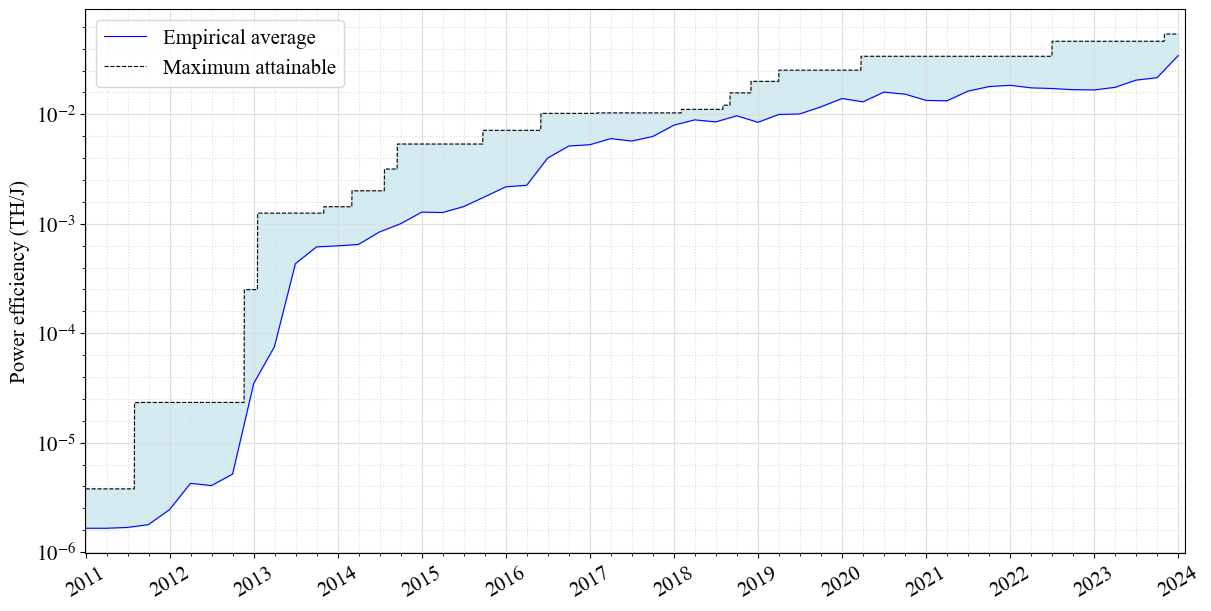

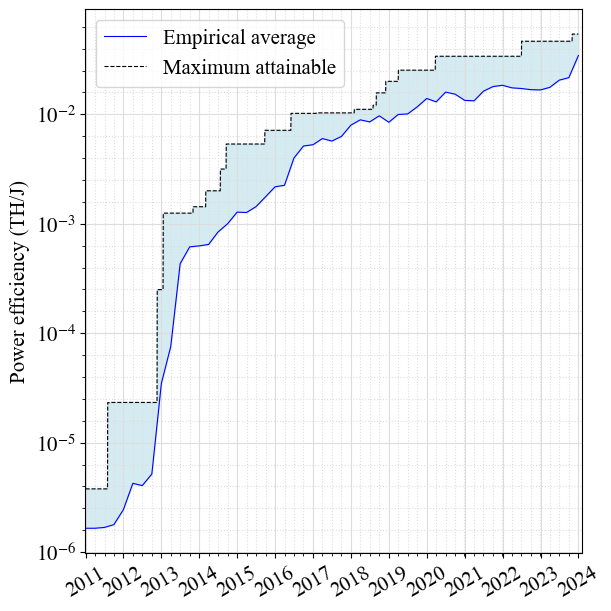

In [62]:
plt.tight_layout()
def plot_efficiency_comparison(ax):
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['mathtext.fontset'] = 'stix'


    # Plot efficiency and max efficiency
    ax.plot(red_scatter_x, red_scatter_y, label='Empirical average', color='blue', linewidth=0.8)
    ax.plot(max_plot_x, max_plot_y, label='Maximum attainable', color='black', linewidth=0.8, linestyle='--')


    # Fill the area, Interpolate red_scatter_y to match the length of max_plot_x
    interp2 = np.interp(max_plot_x, red_scatter_x, red_scatter_y)
    ax.fill_between(max_plot_x, max_plot_y, interp2, interpolate=True, color='lightblue', alpha=0.5)



    # Set x-ticks to every year and format them to include "01.01."
    start = pd.Timestamp('2010-12-31 00:00:00')
    end = pd.Timestamp('2024-01-31 00:00:00')
    years = pd.date_range(start=start, end=end, freq='YS')
    ax.set_xticks(years)
    ax.set_xticklabels([f"{year.year}" for year in years], rotation=30)
    # set xlim
    ax.set_xlim(start, end)

    # Set y-axis label and format y-ticks to display as 10^x
    ax.set_ylabel('Power efficiency (TH/J)', rotation='vertical')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: "$10^{" + str(x-12).replace(".0","") + "}$")) #.rstrip(".0")

    # Set font to Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'

    # Make the font larger
    fs = 15
    plt.rcParams.update({'font.size': fs})

    # Increase DPI
    plt.rcParams.update({'figure.dpi': 100})

    # Rotate x-ticks
    plt.xticks(rotation=30)

    # Add a grid
    # Add more gridlines
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.8)
    ax.minorticks_on()

    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(colors) + 2, fancybox=True, shadow=True)
    # ax.legend(loc='upper left', bbox_to_anchor=(0, 0.9), ncol=1, fancybox=True, shadow=True)
    ax.legend()



plt.rcParams['figure.facecolor'] = 'white'
fig, ax = plt.subplots(figsize=(12, 6))
plot_efficiency_comparison(ax)
plt.savefig('pdfs/efficiencycomparison_wide.pdf', format='pdf', bbox_inches='tight')
plt.show()
fig, ax = plt.subplots(figsize=(6, 6))
plot_efficiency_comparison(ax)
plt.savefig('pdfs/efficiencycomparison_thin.pdf', format='pdf', bbox_inches='tight')
plt.show()

# stuff below is not used

In [63]:
red_scatter_y

0      6.217607
1      6.217607
2      6.224812
3      6.250558
4      6.387446
5      6.628088
6      6.607458
7      6.712812
8      7.541570
9      7.877460
10     8.635081
11     8.788921
12     8.797748
13     8.810923
14     8.924780
15     8.999991
16     9.106203
17     9.102623
18     9.155767
19     9.245640
20     9.337348
21     9.351243
22     9.600503
23     9.710403
24     9.722209
25     9.778277
26     9.755531
27     9.797463
28     9.901203
29     9.949254
30     9.930690
31     9.986245
32     9.927111
33     9.998270
34    10.003196
35    10.067665
36    10.144453
37    10.113681
38    10.202698
39    10.183866
40    10.127070
41    10.123251
42    10.211649
43    10.253393
44    10.265169
45    10.241653
46    10.235679
47    10.225041
48    10.222771
49    10.246263
50    10.312170
51    10.334715
52    10.536717
Name: TH/J, dtype: float64

In [64]:
max_plot_y

0        6.577492
1        6.577492
2        6.577492
3        6.577492
4        6.577492
          ...    
4743    10.733197
4744    10.733197
4745    10.733197
4746    10.733197
4747    10.733197
Name: max_efficiency, Length: 4748, dtype: float64

In [65]:
price_plot_x

0     2023-12-31
1     2023-10-31
2     2023-09-30
3     2023-08-31
4     2023-07-31
         ...    
149   2011-06-30
150   2011-05-31
151   2011-04-30
152   2011-03-31
153   2011-02-28
Name: date, Length: 154, dtype: datetime64[ns]

In [66]:
quarterly_dates = red_scatter_x
data = pd.DataFrame({'Date': gray_scatter_x, 'Performance': gray_scatter_y})
quarterly_data2 = pd.DataFrame({'Date': red_scatter_x, 'Performance': red_scatter_y})

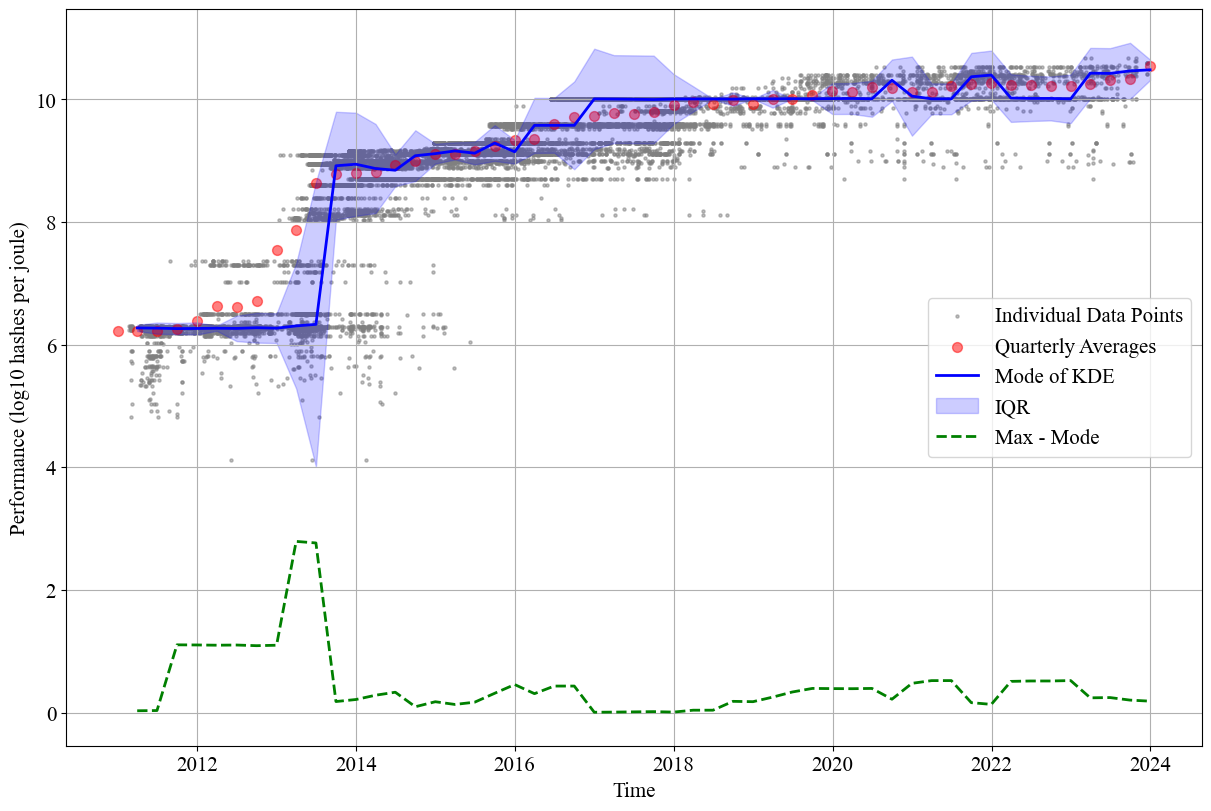

In [67]:
# Function to calculate KDE, extract mode, IQR, and max performance
def analyze_performance(data, bandwidth=0.3):
    kde = gaussian_kde(data['Performance'], bw_method=bandwidth)
    performance_range = np.linspace(data['Performance'].min(), data['Performance'].max(), 500)
    kde_values = kde(performance_range)
    mode = performance_range[np.argmax(kde_values)]
    iqr = np.subtract(*np.percentile(data['Performance'], [75, 25]))
    max_performance = data['Performance'].max()
    return mode, iqr, max_performance

# Analyzing each quarter
results = []
for date in red_scatter_x:
    quarter_start = date - pd.offsets.QuarterBegin(startingMonth=1)
    quarter_end = date
    quarter_data = data[(data['Date'] >= quarter_start) & (data['Date'] <= quarter_end)]
    if not quarter_data.empty:
        mode, iqr, max_performance = analyze_performance(quarter_data)
        results.append({'Date': date, 'Mode': mode, 'IQR': iqr, 'Max': max_performance, 'Max-Mode': max_performance - mode})

results_df = pd.DataFrame(results)

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(data['Date'], data['Performance'], c='gray', s=5, label='Individual Data Points', alpha=0.5)
plt.scatter(quarterly_data2['Date'], quarterly_data2['Performance'], c='red', s=50, label='Quarterly Averages', alpha=0.5)
plt.plot(results_df['Date'], results_df['Mode'], label='Mode of KDE', color='blue', linewidth=2)
plt.fill_between(results_df['Date'], results_df['Mode'] - results_df['IQR'], results_df['Mode'] + results_df['IQR'], color='blue', alpha=0.2, label='IQR')
plt.plot(results_df['Date'], results_df['Max-Mode'], label='Max - Mode', color='green', linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Performance (log10 hashes per joule)')
plt.legend()
plt.grid(True)
plt.show()

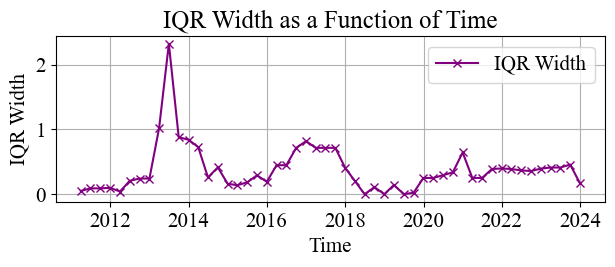

In [68]:


# Plotting the IQR width as a function of time
plt.subplot(2, 1, 2)
plt.plot(results_df['Date'], results_df['IQR'], label='IQR Width', color='purple', marker='x')
plt.xlabel('Time')
plt.ylabel('IQR Width')
plt.title('IQR Width as a Function of Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()